### Project Topic

This project explores the application of supervised learning techniques to classify mushrooms as either **edible** or **poisonous**. This is a **binary classification problem** as the task is to predict one of two discrete classes. 

The primary goal of this project is to:
1.  Demonstrate the process of supervised learning by applying multiple machine learning algorithms to a real-world classification task.
2.  Learn and implement advanced techniques such as hyperparameter tuning, feature engineering, and model evaluation.
3.  Showcase performance metrics and comparisons to determine the most effective model for the task.
4.  Highlight the importance of accurate classification in practical scenarios, such as identifying potentially dangerous mushrooms.

### Data 

The dataset used is the **Secondary Mushroom Dataset** from the UCI Machine Learning Repository.
> Dua, D., & Graff, C. (2019). UCI Machine Learning Repository [Secondary Mushroom Dataset]. Retrieved from [https://archive.ics.uci.edu/dataset/848/secondary+mushroom+datase](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+datase).


This dataset was curated as a simulated dataset for binary classification tasks, specifically focusing on the edibility of mushrooms based on their features. It provides diverse feature types and a large number of samples, making it suitable for exploring advanced machine learning techniques and evaluating model performance comprehensively.

The data is sourced into this notebook using the `ucimlrepo` package.

#### Data Description

- **Number of Samples:** 61,068
- **Number of Features:** 20
- **Feature Types:**
  - Categorical features (e.g., cap shape, surface, color, etc.)
  - Continuous features (e.g., numerical indicators for specific measurements: cap diameter, stem height & width)
- **Task Type:** Binary classification (edible or poisonous)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ucimlrepo import fetch_ucirepo 

In [44]:
# Thanks, UCI_ML_Repo!
# fetch dataset 
secondary_mushroom = fetch_ucirepo(id=848) 
# data (as pandas dataframes) 
X = secondary_mushroom.data.features 
y = secondary_mushroom.data.targets 
  
# metadata 
# print(secondary_mushroom.metadata) 
# variable information 
print(secondary_mushroom.variables) 

                    name     role         type demographic description units  \
0                  class   Target  Categorical        None        None  None   
1           cap-diameter  Feature   Continuous        None        None  None   
2              cap-shape  Feature  Categorical        None        None  None   
3            cap-surface  Feature  Categorical        None        None  None   
4              cap-color  Feature  Categorical        None        None  None   
5   does-bruise-or-bleed  Feature  Categorical        None        None  None   
6        gill-attachment  Feature  Categorical        None        None  None   
7           gill-spacing  Feature  Categorical        None        None  None   
8             gill-color  Feature  Categorical        None        None  None   
9            stem-height  Feature   Continuous        None        None  None   
10            stem-width  Feature   Continuous        None        None  None   
11             stem-root  Feature  Categ

In [45]:
''' 
Exploratory Data Analysis [Part 1]

The variable information printed above shows that several features were missing values.
In order to not out right break certain my ***UPDATE THIS*** logisitic regression model or to degrade performance of my other models, 
I inspected the percentage of samples missing the particular features. I decided to remove features with more than 30% of values missing
to avoid causing collinearity among the features (e.g., associating a missing veil-type with poisonous if by chance 
many poisonous records were missing a veil-type, etc.). 
For the rest with missing values I added a new, unique value (?) to represent missing. This was a viable option because the features 
in scope were all categorical instead of continuous.
'''

missing_proportions = X.isnull().mean() * 100
missing_features = missing_proportions[missing_proportions > 0].sort_values(ascending=False)
print("Missing values (%) from source dataset:")
print(missing_features)
print('Cleaning data...', end='\n\n')

features_to_drop = missing_proportions[missing_proportions > 30].index
X_cleaned = X.drop(columns=features_to_drop)

features_to_mod = missing_proportions[missing_proportions <= 30].index
for f in features_to_mod:
    X_cleaned.fillna({ f: "?" }, inplace=True)

missing_proportions_check = X_cleaned.isnull().mean() * 100
missing_features_check = missing_proportions_check[missing_proportions_check > 0]
assert len(missing_features_check) == 0, 'Data is not cleaned as expected'
X = X_cleaned
print('Data is clean and ready to explore, train, and test!')
print(X.head())

Missing values (%) from source dataset:
veil-type            94.797688
spore-print-color    89.595376
veil-color           87.861272
stem-root            84.393064
stem-surface         62.427746
gill-spacing         41.040462
cap-surface          23.121387
gill-attachment      16.184971
ring-type             4.046243
dtype: float64
Cleaning data...

Data is clean and ready to explore, train, and test!
   cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0         15.26         x           g         o                    f   
1         16.60         x           g         o                    f   
2         14.07         x           g         o                    f   
3         14.17         f           h         e                    f   
4         14.64         x           h         o                    f   

  gill-attachment gill-color  stem-height  stem-width stem-color has-ring  \
0               e          w        16.95       17.09          w        t   
1       

In [4]:
'''
Exploratory Data Analysis [Part 2]

'''
None

In [5]:
print(type(y))
y_col = y.iloc[:, 0]
print(type(y_col))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


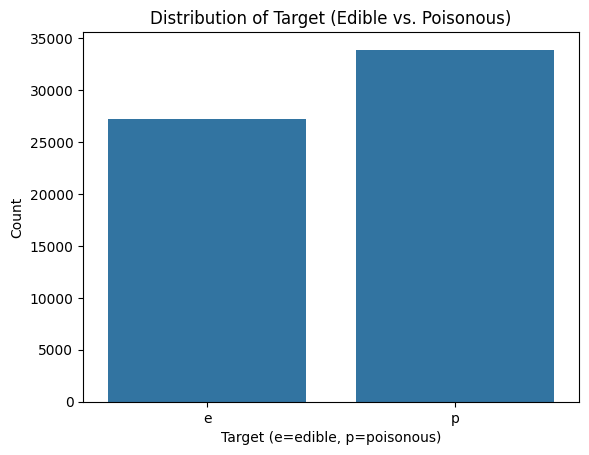

In [52]:
sns.countplot(x=y_col, order=['e', 'p'])
plt.title("Distribution of Target (Edible vs. Poisonous)")
plt.xlabel("Target (e=edible, p=poisonous)")
plt.ylabel("Count")
plt.show()

In [53]:
num_features = X.select_dtypes(include=['float64'])
cat_features = X.select_dtypes(include=['object'])
print(str(len(num_features.columns)) + ' numeric features')
print(str(len(cat_features.columns)) + ' categorical features')

3 numeric features
11 categorical features


In [61]:
from sklearn.preprocessing import LabelEncoder

def encode_data(data, le_dict = {}):
    for col in data.select_dtypes(include=['object']):
        le = LabelEncoder()
        X[col] = le.fit_transform(data[col])
        le_dict[col] = le
    return le_dict

def decode_data(data, le_dict):
    for col, le in le_dict.items():
        data[col] = le.inverse_transform(data[col])

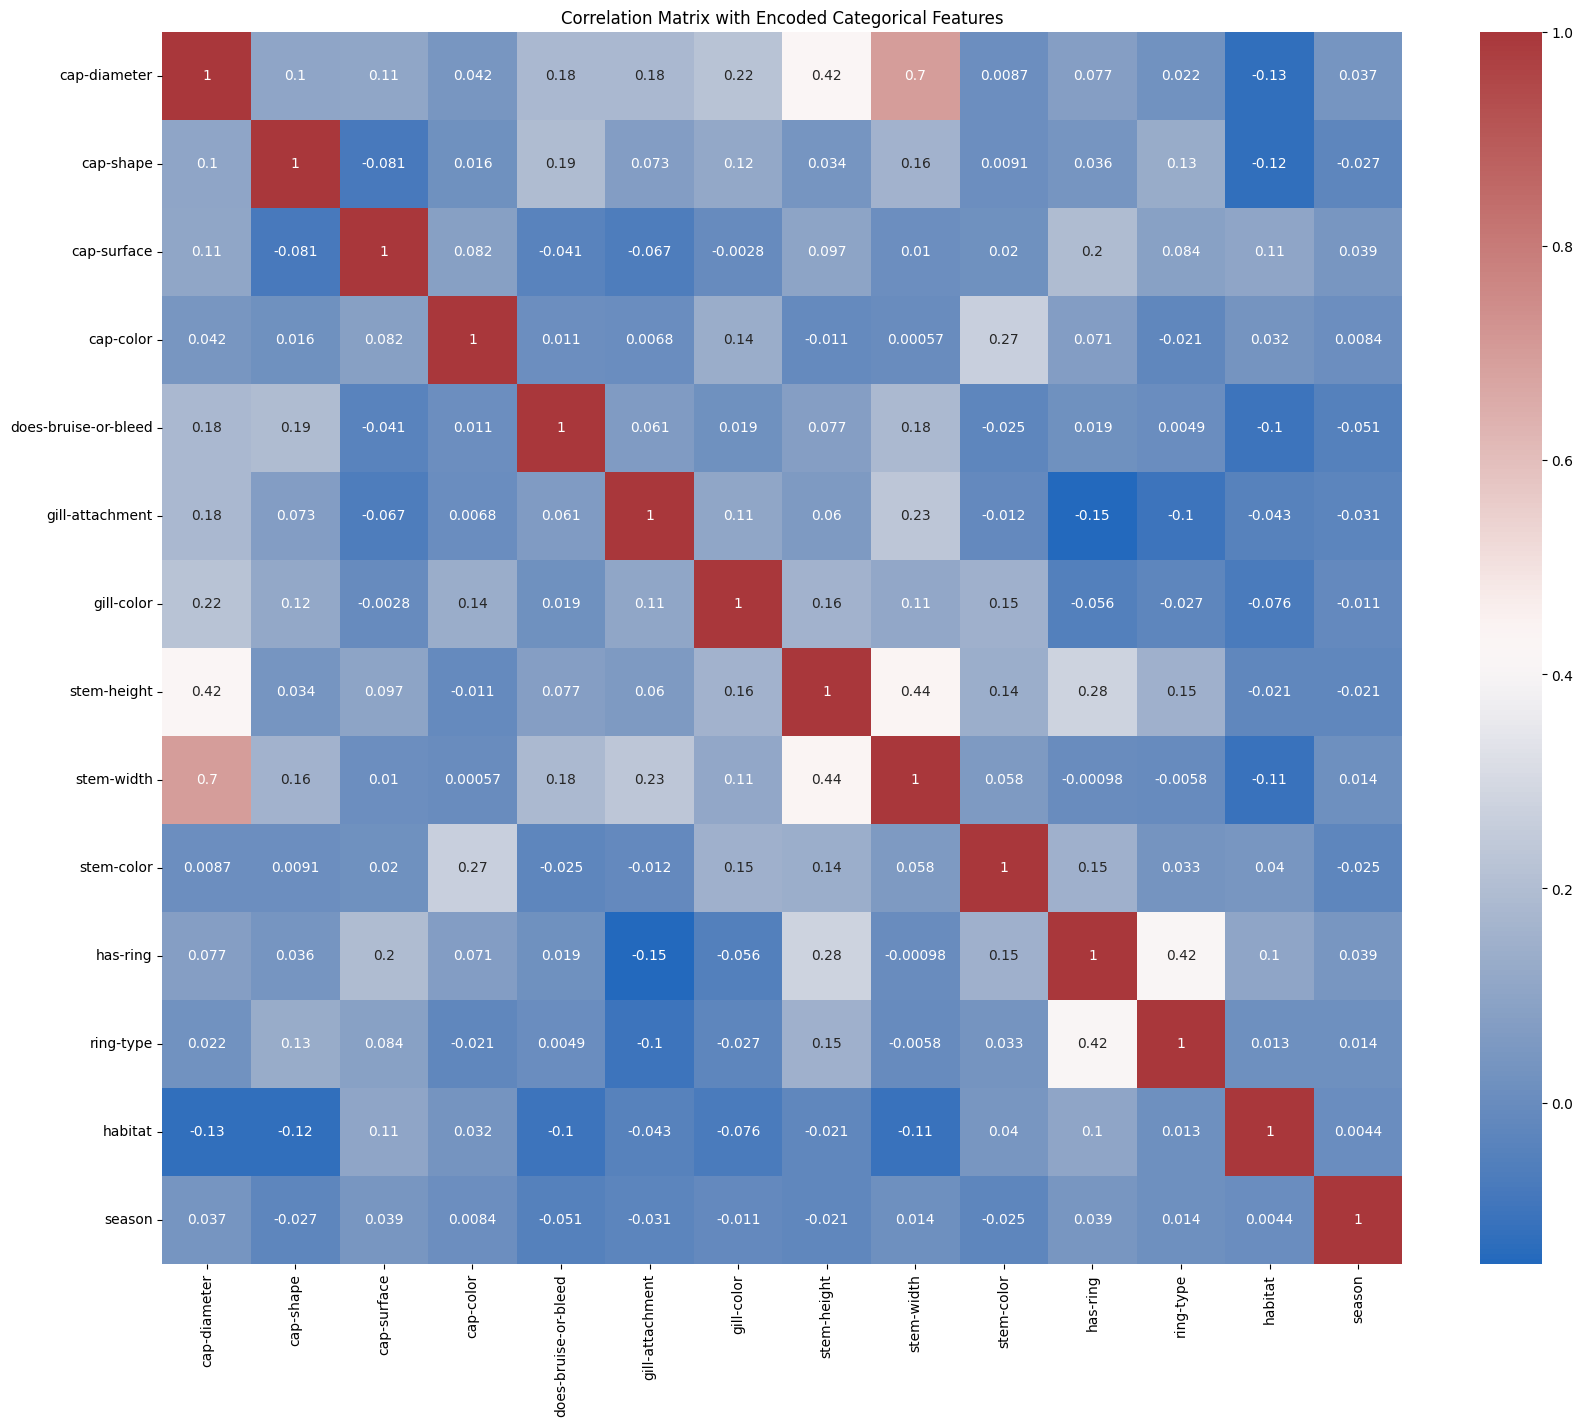

In [62]:
le_dict_X = encode_data(X)
plt.figure(figsize=(20,16))
sns.heatmap(X.corr(), cmap='vlag', annot=True)
plt.title("Correlation Matrix with Encoded Categorical Features")
plt.show()
decode_data(X, le_dict_X)

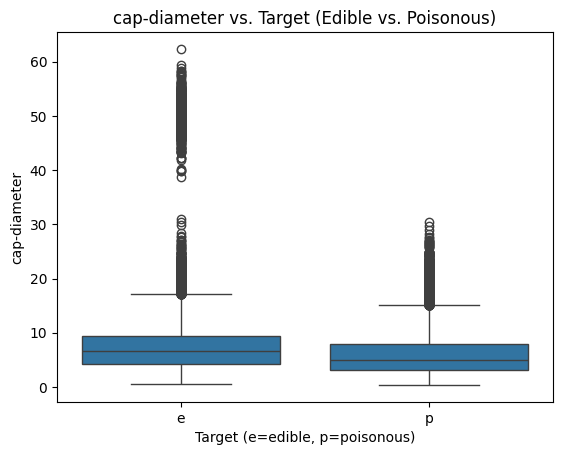

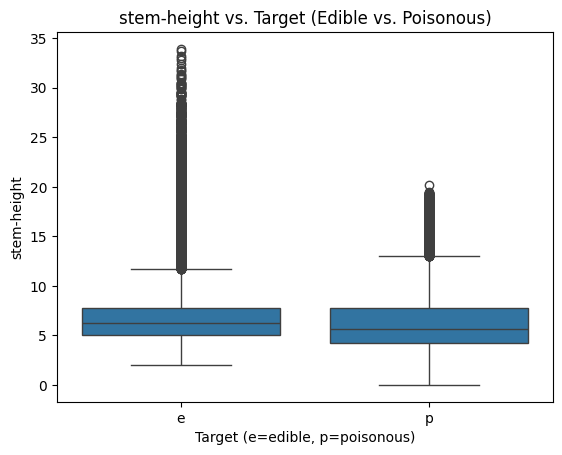

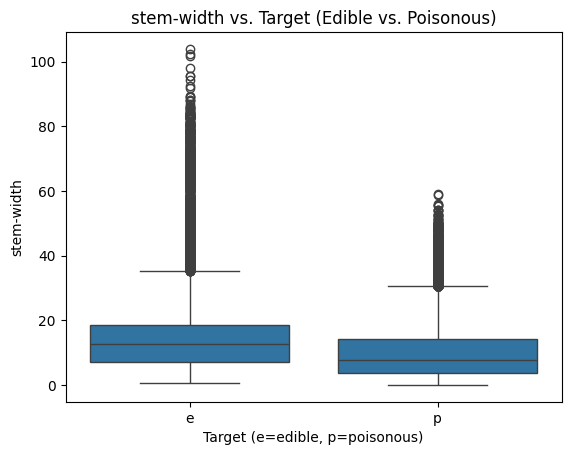

In [57]:
for f in num_features:
    sns.boxplot(x=y_col, y=f, data=X, order=['e', 'p'])
    plt.title(f + ' vs. Target (Edible vs. Poisonous)')
    plt.xlabel('Target (e=edible, p=poisonous)')
    plt.show()

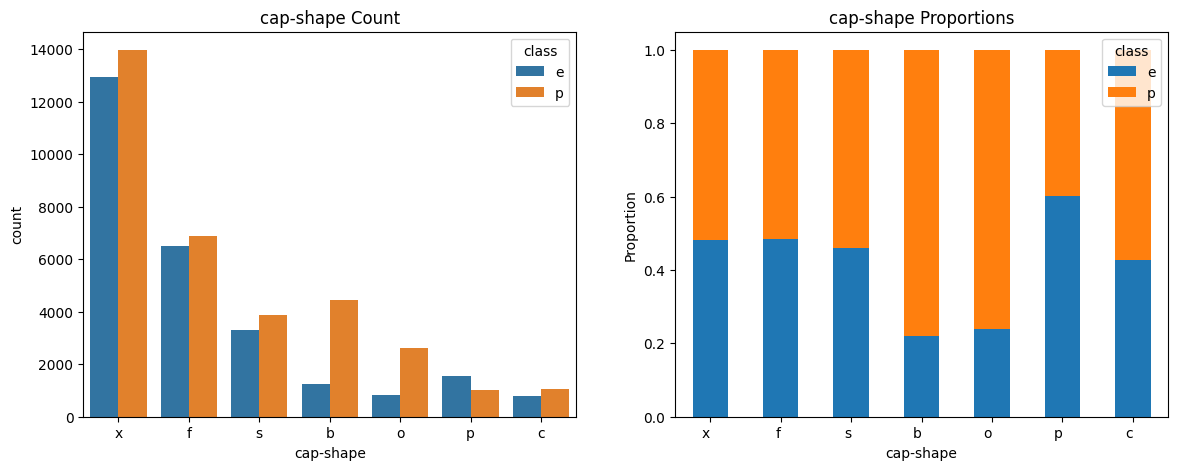

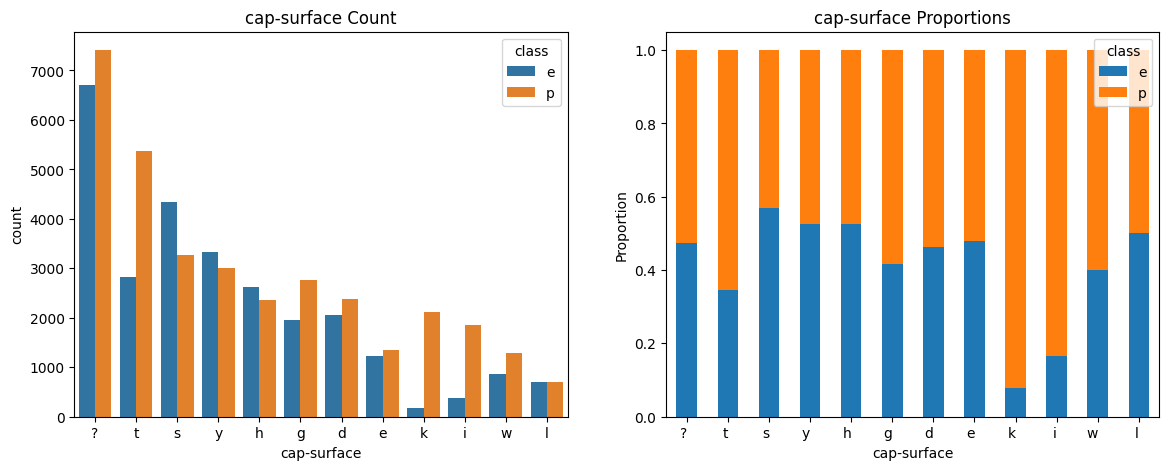

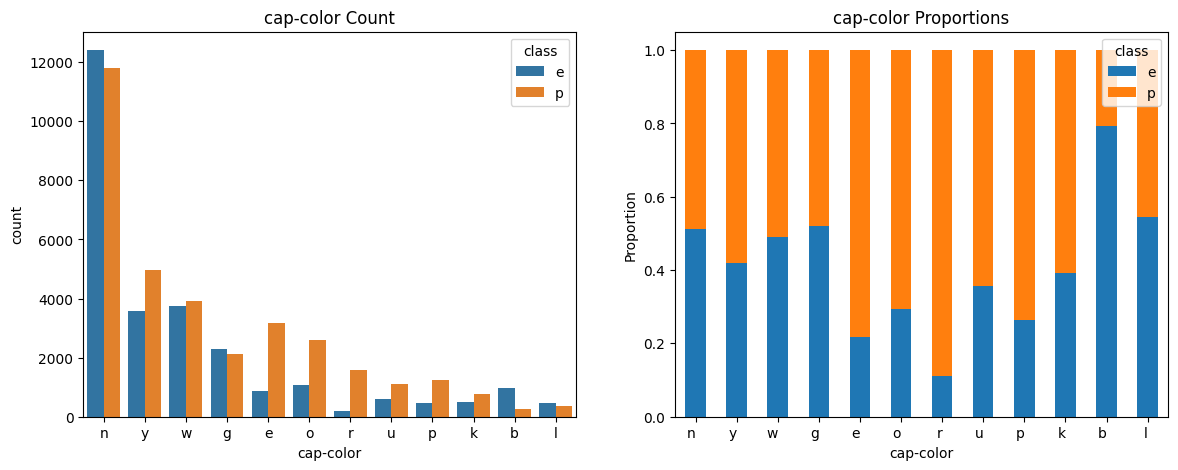

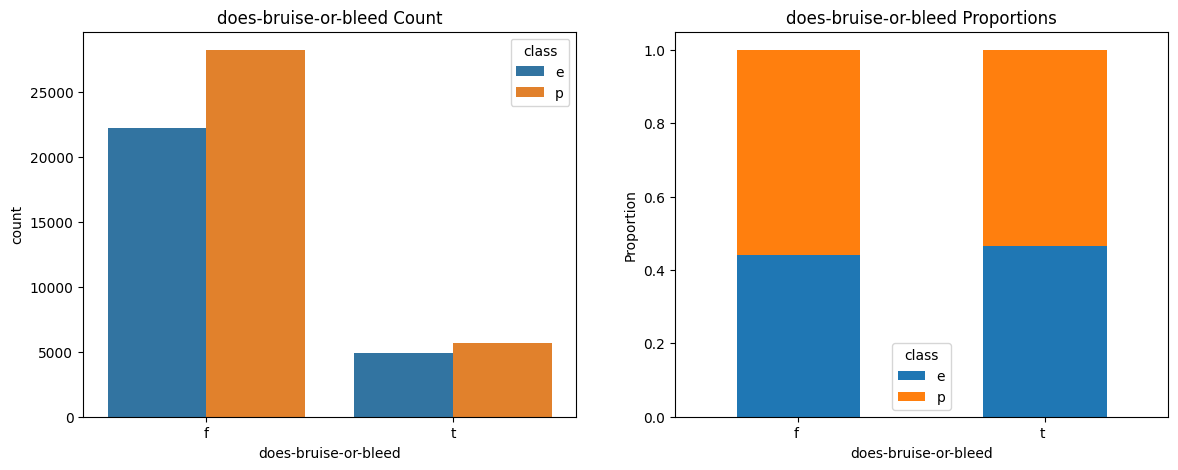

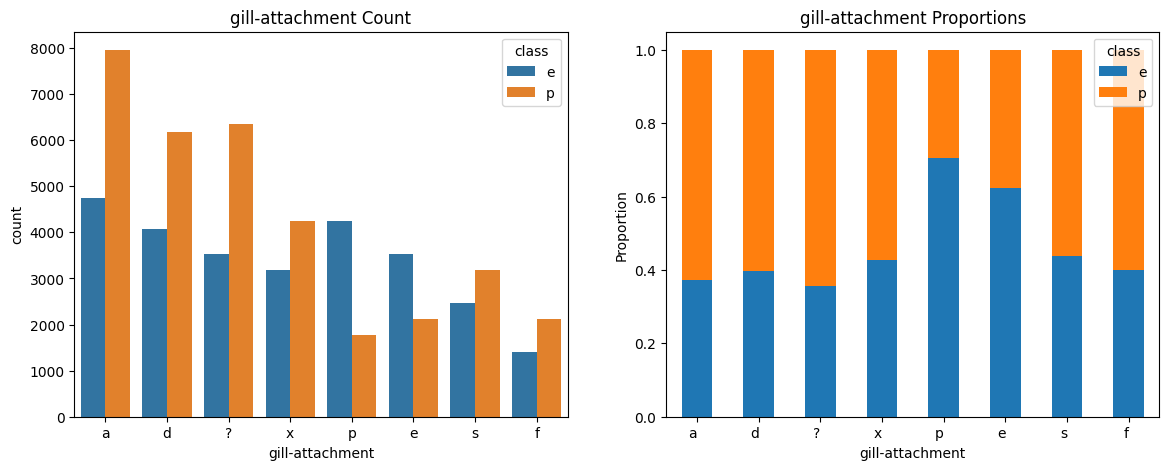

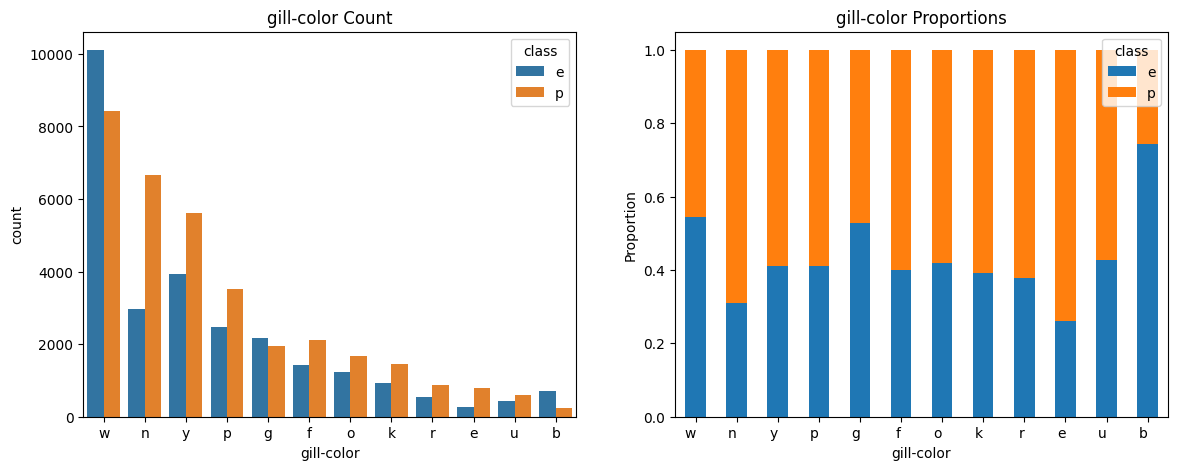

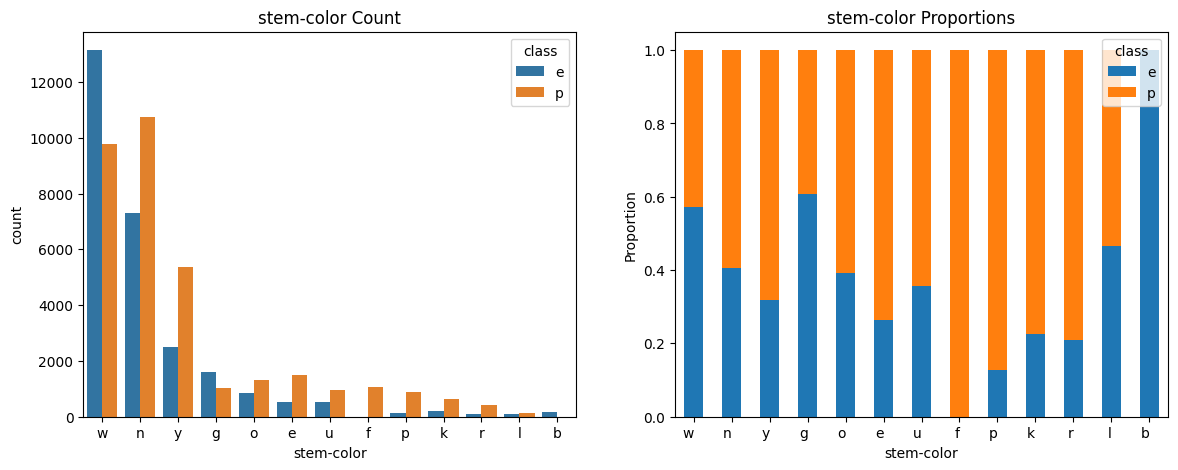

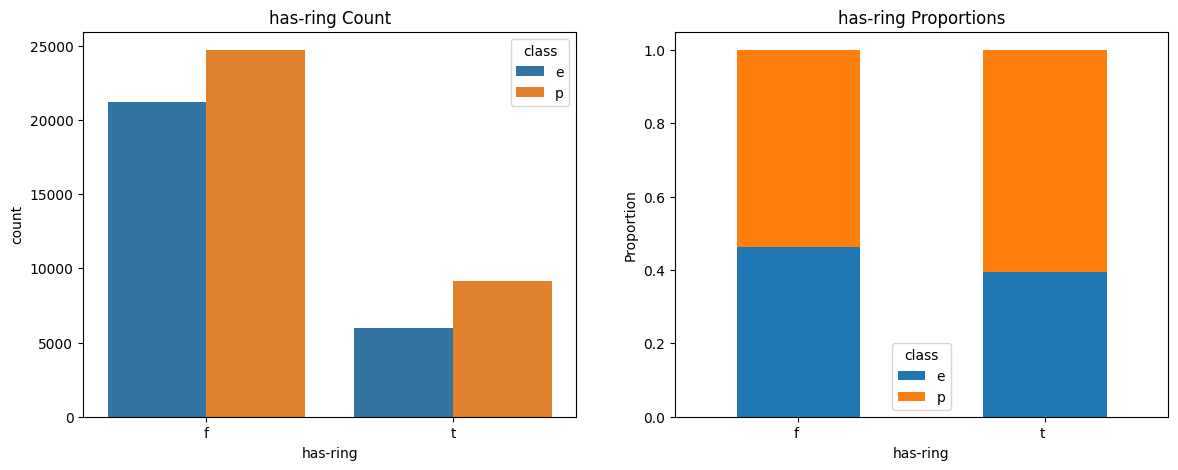

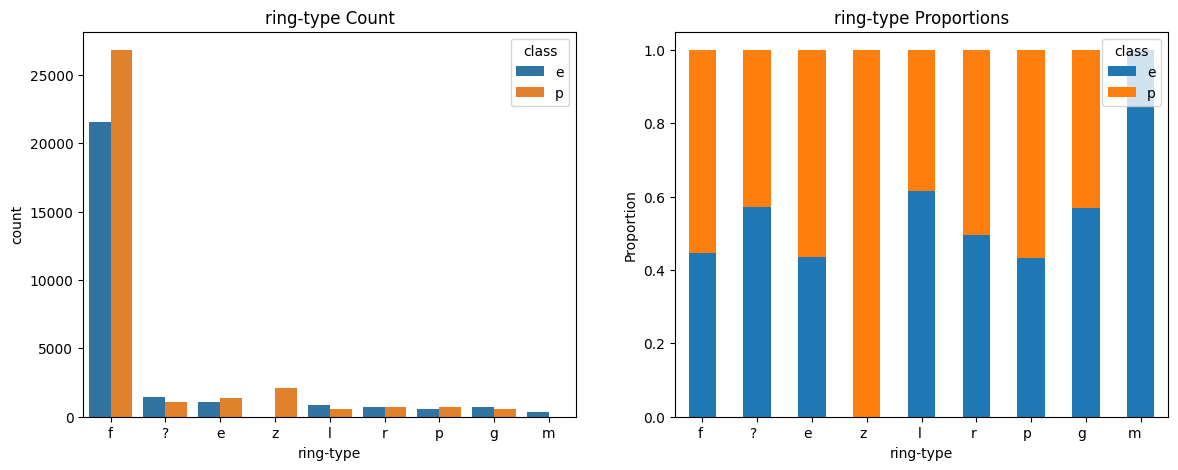

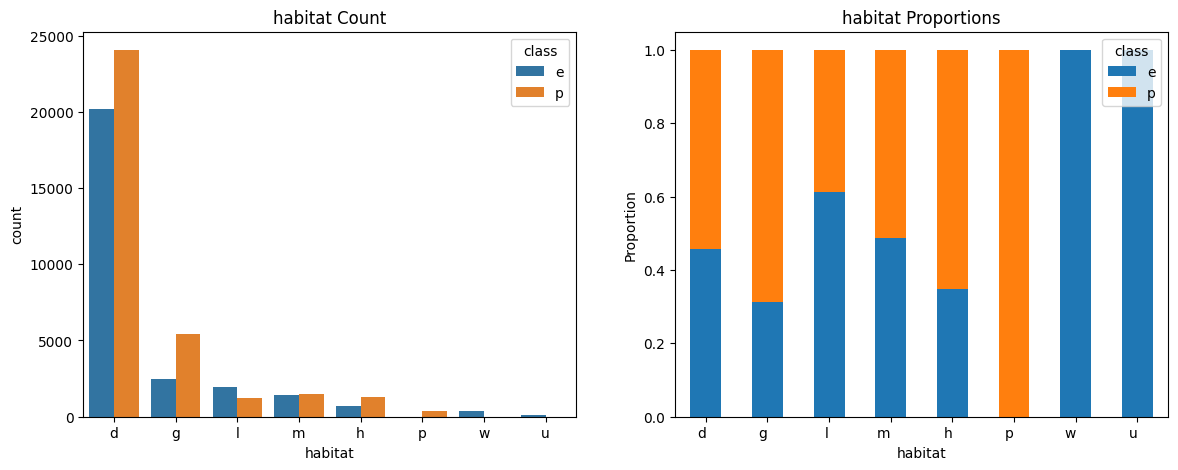

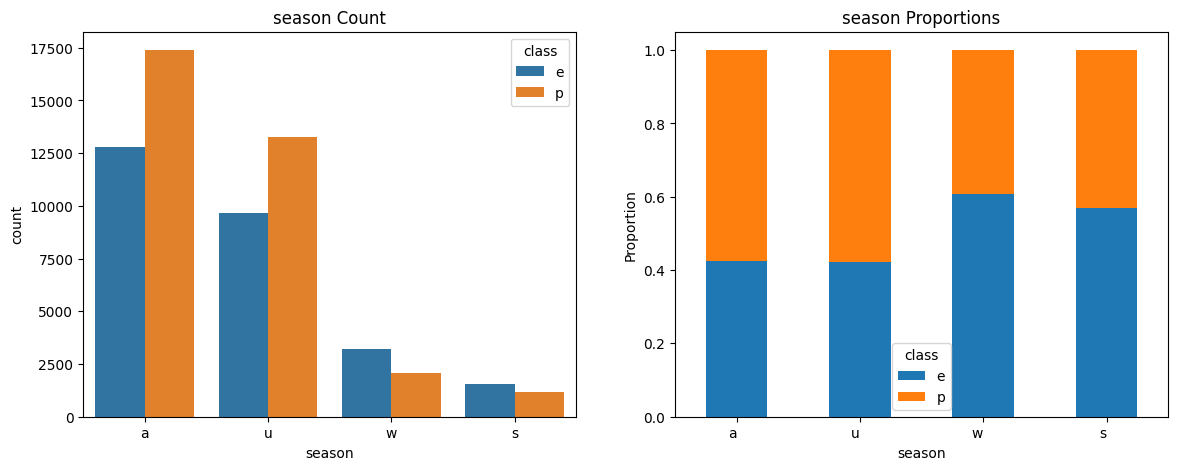

In [63]:
for f in cat_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    order = X[f].value_counts().index
    
    sns.countplot(x=f, hue=y_col, data=X, ax=axes[0], order=order, hue_order=['e', 'p'])
    axes[0].set_title(f + ' Count')
    
    proportions = X.groupby([f, y_col]).size().unstack().reindex(index=order)
    proportions.div(proportions.sum(axis=1), axis=0).plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title(f + ' Proportions')
    axes[1].set_ylabel("Proportion")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0, ha='right')

    plt.show()


In [65]:
'''
Models

'''

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [82]:
from sklearn.model_selection import train_test_split

le_dict_X, le_dict_y = encode_data(X), encode_data(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=28)

In [84]:
rf_model = RandomForestClassifier().fit(X_train, y_train.iloc[:, 0])